## Introduction section

In [96]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.utils.random import sample_without_replacement
from imblearn.under_sampling import RandomUnderSampler

# create dataset
N = 100000
X, y = make_blobs(
    n_samples=N, n_features=2, centers=[[0, 0]], cluster_std=3, random_state=2
)
mins = X.min(axis=0)
maxs = X.max(axis=0)


def add_noise(X, y):
    X2 = np.random.rand(int(N * 0.2), 2)
    y2 = np.full(int(N * 0.2), -1)
    X2[:, 0] = (X2[:, 0] * (maxs[0] - mins[0])) + mins[0]
    X2[:, 1] = (X2[:, 1]) * (maxs[1] - mins[1]) + mins[1]

    X_ = np.concatenate([X, X2], axis=0)
    y_ = np.concatenate([y, y2], axis=0)
    return X_, y_


X, y = add_noise(X, y)


def cluster(X, y):
    clustering = DBSCAN(eps=0.32, min_samples=100).fit(X)
    c = clustering.labels_
    return c


def to_df(X, y):
    df = pd.DataFrame(X, columns=["A, B"])
    df["y"] = y
    return df


def draw_uniform_sample(X, y, n_sample: int):
    # shuffle the input data
    random = np.random.rand(len(X))
    random_order = np.argsort(random)
    X_ = X[random_order]

    # draw random sample
    sample = sample_without_replacement(
        n_population=len(X_), n_samples=n_sample, random_state=0
    )

    return to_df(X[sample], y[sample])


def draw_inlier_sample(X, y, n_sample: int):
    # dbscan: -1 is outlier, so inlier is > -1
    c = cluster(X, y)
    c = (c > -1).astype(int)

    # in case there are more than n_sample inliers, sample down uniformly
    return draw_uniform_sample(X[c == 1], c[c == 1], n_sample=n_sample)


def draw_stratified_sample(X, y, n_sample: int):
    c = cluster(X, y)
    c = (c > -1).astype(int)

    # clustering might find more than 2 clusters, but all we need is inlier/outliere(int)

    rus = RandomUnderSampler()
    X_, y_ = rus.fit_resample(X, c)
    return draw_uniform_sample(X_, y_, n_sample=n_sample)


def draw_noise_sample(X, y, n_sample: int):
    c = cluster(X, y)
    c = (c > -1).astype(int)

    return draw_uniform_sample(X[y == -1], c[y == -1], n_sample)


def draw_outlier_sample(X, y, n_sample: int):
    # dbscan: -1 is outlier, so inlier is > -1
    c = cluster(X, y).astype(int)

    return draw_uniform_sample(X[c == -1], c[c == -1], n_sample)


In [7]:
import os, sys
sys.path.append(f"{os.getcwd()}/../")

from pipeline.Pipeline import Pipeline
from linearizations.Linearization import *


# noise sampling
noise_config = {
  "data": "test",
  "linearization": "numeric",
  "subdivision": "cardinality",
  "selection": "random",
  "dimension": 2,
  "params": {
    "subspace": [0, 1]
  }
}

# stratified sampling
stratified_config = {
  "data": "test",
  "linearization": "numeric",
  "subdivision": "cohesion",
  "selection": "random",
  "dimension": 2,
  "params": {
    "subspace": [0, 1]
  }
}

# outlier sampling
outlier_config = {
  "data": "test",
  "linearization": "numeric",
  "subdivision": "cardinality",
  "selection": "minimum",
  "dimension": 2,
  "params": {
    "subspace": [0, 1]
  }
}

# uniform sampling
uniform_config = {
  "data": "test",
  "linearization": "numeric",
  "subdivision": "cardinality",
  "selection": "random",
  "dimension": 2,
  "params": {
    "subspace": [0, 1]
  }
}

noise_pl = Pipeline(noise_config)
stratified_pl = Pipeline(stratified_config)
outlier_pl = Pipeline(outlier_config)
uniform_pl = Pipeline(uniform_config)

preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing


In [6]:
import pandas as pd

pd.read_csv("./linearization_files/testLinearizationRandom.csv", sep=";", names=["A", "B", "y"])

,A,B,y
0,136478.0,0.839385,0.0
1,189276.0,3.600026,0.0
2,97429.0,-2.591145,0.0
3,151040.0,-0.326331,0.0
4,135080.0,-7.176725,-1.0
...,...,...,...
199995,178082.0,-1.245067,0.0
199996,1705.0,-0.790083,0.0
199997,177131.0,-1.232019,0.0
199998,5286.0,7.273714,-1.0


### Plot full dataset

(-12.48393401358247, 14.190341438793237)

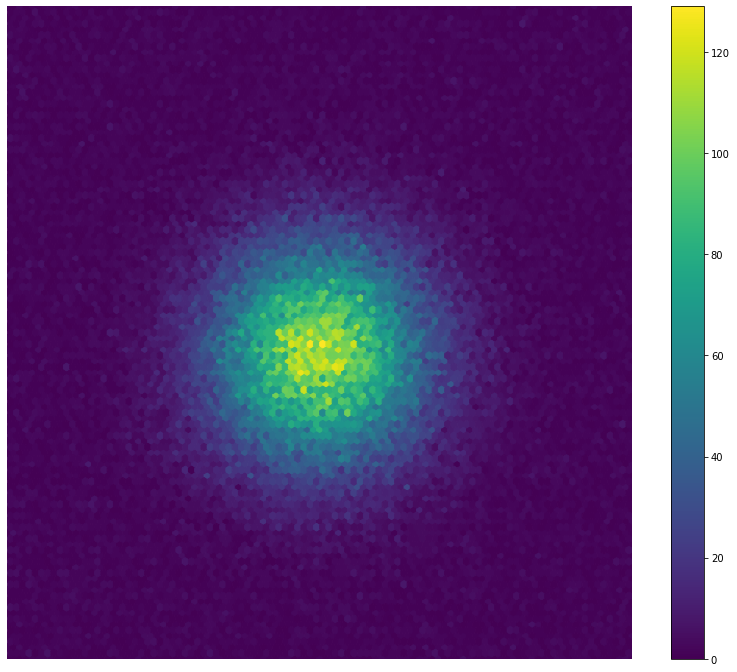

In [4]:
df = pd.DataFrame(X, columns=["A, B"])
plt = df.plot.hexbin(
  x='A',
  y='B',
  reduce_C_function=np.sum,
  gridsize=100,
  cmap="viridis",
  figsize=[14, 12],
)

plt.axis("off")
plt.set_xlim([mins[0], maxs[0]])
plt.set_ylim([mins[1], maxs[1]])

### Plot different sampling tasks on that dataset

Adjust the first lines to draw a different sample.

(-12.48393401358247, 14.190341438793237)

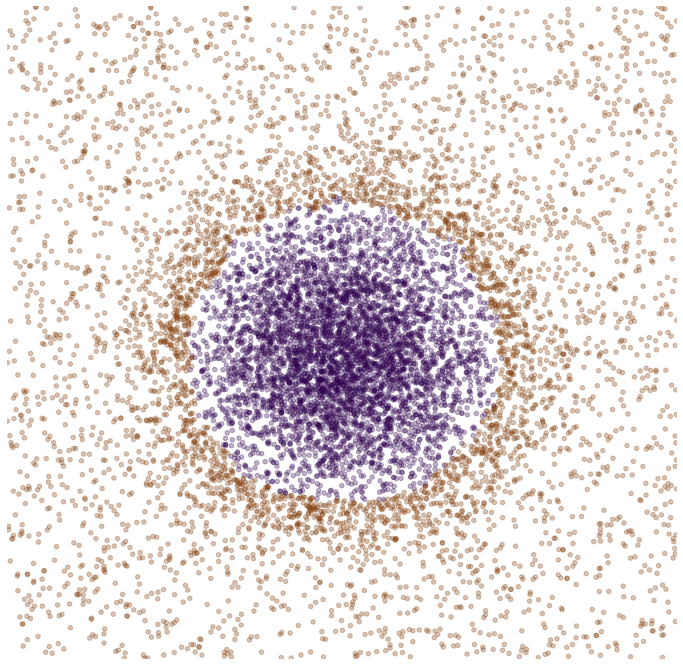

In [3]:
# plot a sampling
# df = draw_noise_sample(X, y, 10000)
df = draw_stratified_sample(X, y, 10000)
# df = draw_outlier_sample(X, y, 10000)
# df = draw_inlier_sample(X, y, 10000)
# df = draw_uniform_sample(X, y, 10000)

plt = df.plot.scatter(
  x="A", 
  y="B", 
  # c="#2f124b", 
  c="y",
  colormap="PuOr", 
  alpha=0.3, 
  figsize=[12, 12], 
  colorbar=False,
)

plt.axis("off")
plt.set_xlim([mins[0], maxs[0]])
plt.set_ylim([mins[1], maxs[1]])

## Pipeline section

Rendering functions used in the following examples:

In [46]:
import sys, os

sys.path.append(f"{os.getcwd()}/../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pipeline.Pipeline import Pipeline

columns = [
    "tripID",
    "VendorID",
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "passenger_count",
    "trip_distance",
    "RatecodeID",
    "PULocationID",
    "DOLocationID",
    "payment_type",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "PURepresentativeX",
    "PURepresentativeY",
    "DORepresentativeX",
    "DORepresentativeY",
    "normalized_value",
    "normalized_spatial_lag",
    "value_is_H",
    "spatial_lag_is_H",
]

gt_df = pd.read_csv(
    "./linearization_files/taxisLinearizationRandom.csv", sep=";", names=columns
)
gt_df["tpep_pickup_datetime"] = pd.to_datetime(gt_df["tpep_pickup_datetime"])

n_bins = 100


def plot_delta_hist(df: pd.DataFrame, facet: str, attr: str = "trip_distance"):
    cases = df[facet].unique()
    # make sure there are at least two plots so that the ax[i] works
    fig, ax = plt.subplots(nrows=1, ncols=cases.size, figsize=(len(cases) * 10, 3.5))

    df_ = gt_df[attr]

    if type(gt_df[attr].iloc[0]) == pd.Timestamp:
        bins = pd.date_range(df_.min(), df_.max(), periods=n_bins + 1)
    else:
        bins = np.linspace(
            df_.min(), df_.max(), n_bins + 1
        )  # because arange does not include max

    gt_bins = np.histogram(df_, bins=bins)[0]
    gt_bins = gt_bins / gt_bins.sum()

    for i, case in enumerate(cases):
        # compute the relative difference in value distributions from the "ground truth"
        df_ = df[df[facet] == case]
        df_bins = np.histogram(df_[attr], bins=bins)[0]
        df_bins = df_bins / df_bins.sum()

        delta = df_bins - gt_bins
        color = ["#1b9e77" if value > 0 else "#7570b3" for value in delta]

        ax_ = ax[i] if len(cases) > 1 else ax
        ax_.bar(
            np.arange(0, len(delta)),
            height=delta,
            color=color,
            width=1,
            edgecolor="black",
            linewidth=1,
        )
        ax_.set_ylim(-0.5, 0.5)
        ax_.get_xaxis().set_visible(False)
        ax_.get_yaxis().set_visible(False) if i > 0 else None

    plt.tight_layout()
    fig.show()


def plot_hist(df: pd.DataFrame, facet: str, attr: str = "trip_distance"):
    g = sns.FacetGrid(
        data=df,
        col=facet,
        palette="colorblind",
        height=3.5,
        aspect=2.8,
    )

    min_value = pd.to_numeric(gt_df[attr]).min()
    max_value = pd.to_numeric(gt_df[attr]).max()
    
    g.map(
        sns.histplot,
        attr,
        bins=n_bins,
        binrange=[min_value, max_value],
        # log_scale=True,
        legend=True,
    )

    g.set_titles(col_template="{col_name}", row_template=f"{facet}" + ": {row_name}")
    g.fig.suptitle(facet, y=1)
    g.add_legend()
    g.fig.show()


def plot_multi_hist(df: pd.DataFrame, facet: str):
    plot_hist(df, facet, "trip_distance")
    plot_hist(df, facet, "tpep_pickup_datetime")


def plot_multi_delta_hist(df: pd.DataFrame, facet: str):
    plot_delta_hist(df, facet, "trip_distance")
    plot_delta_hist(df, facet, "tpep_pickup_datetime")


def plot_geo(df: pd.DataFrame, facet: str, attr: str = "trip_distance"):
    df["group"] = pd.qcut(df[attr].astype(np.float64), q=4)

    g = sns.relplot(
        data=df,
        x="PURepresentativeX",
        y="PURepresentativeY",
        col=facet,
        row="group",
        kind="scatter",
        hue=attr,
        # size=0.1,
        palette="viridis",
        height=4,
        alpha=0.3,
    )
    g.fig.suptitle(facet, y=1)
    g.add_legend()


def plot_geo_dist(df: pd.DataFrame, facet: str):
    sns.set_palette("ch:start=.2,rot=-.3")
    g = sns.FacetGrid(
        data=df,
        col=facet,
        height=5,
    )
    g.map_dataframe(
        sns.histplot,
        x="PURepresentativeX",
        y="PURepresentativeY",
        bins=100,
        legend=True,
    )
    sns.set_palette("ch:start=.2,rot=-.3")


def plot_moran(df: pd.DataFrame, facet: str):
    df["moran_label"] = df["value_is_H"].astype(str) + df["spatial_lag_is_H"].astype(
        str
    )

    # g = sns.relplot(
    #     data=df,
    #     x="normalized_value",
    #     y="normalized_spatial_lag",
    #     hue="moran_label",
    #     col=facet,
    #     kind="scatter",
    #     # size=0.1,
    #     height=4,
    #     alpha=0.3,
    #     legend=False,
    # )

    # g.refline(x=0, y=0, color="black")

    g = sns.FacetGrid(df, col=facet, height=3, aspect=2)
    g.map_dataframe(sns.histplot, y="moran_label", hue="moran_label")


def render_chunk(df: pd.DataFrame, facet: str or list[str]):
    if type(facet) == list:
        facets = facet.copy()
        facet = "--".join(facet)
        df[facet] = ""
        for f in facets:
            df[facet] += df[f].astype(str) + " "

    # plot_hist(df, facet)
    # plot_delta_hist(df, facet)
    
    plot_multi_hist(df, facet)
    # plot_geo(df, facet)
    plot_geo_dist(df, facet)
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    plot_multi_delta_hist(df, facet)
    # plot_moran(df, facet)


Base configuration:

In [2]:
base_config = {
  "data": "taxis",
  "linearization": "random",
  "subdivision": "cardinality",
  "selection": "maximum",
  "dimension": 5,  # trip distance
  "params": {
    "subspace": [17, 18],  # pickup location,
    # "coverage": 16,  # total amount
    "coverage": 5,  # trip distance
    "value_h_index": 23,
    "lag_h_index": 24,
  }
}

preprocessing pipeline ...
Done with the pre-processing


C:\Users\au629923\AppData\Local\Temp\ipykernel_6172\3216441274.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\au629923\AppData\Local\Temp\ipykernel_6172\3216441274.py:66: RuntimeWarning: invalid value encountered in true_divide
  df_bins = df_bins / df_bins.sum()


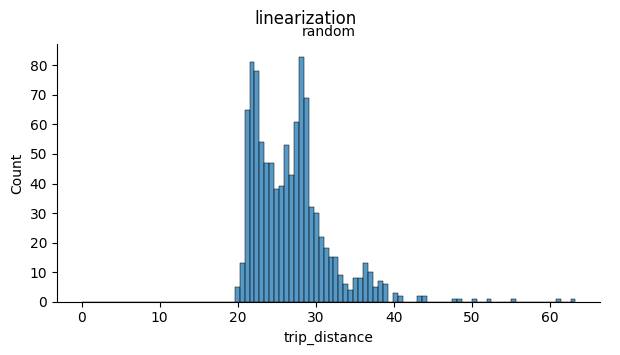

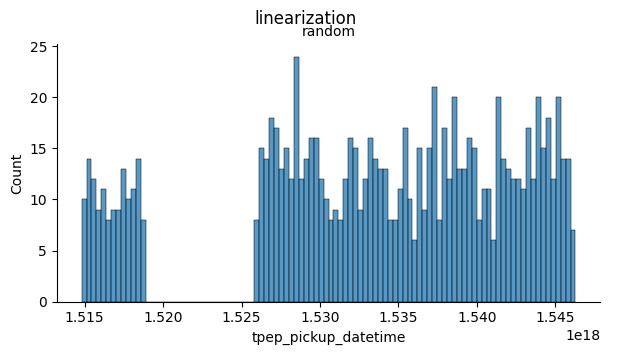

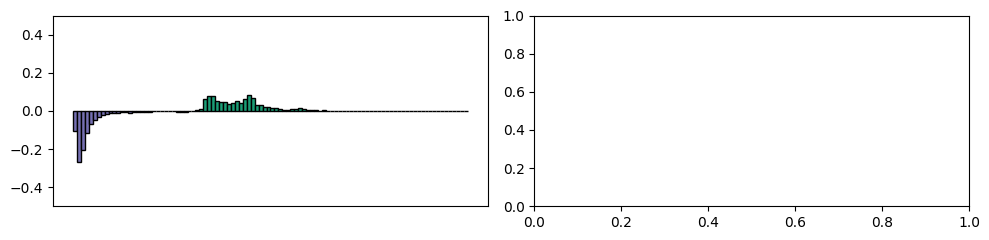

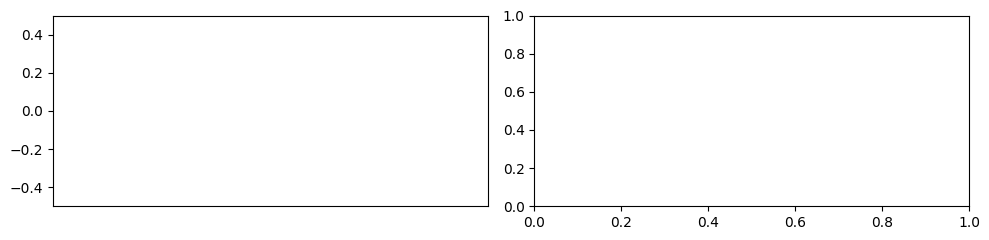

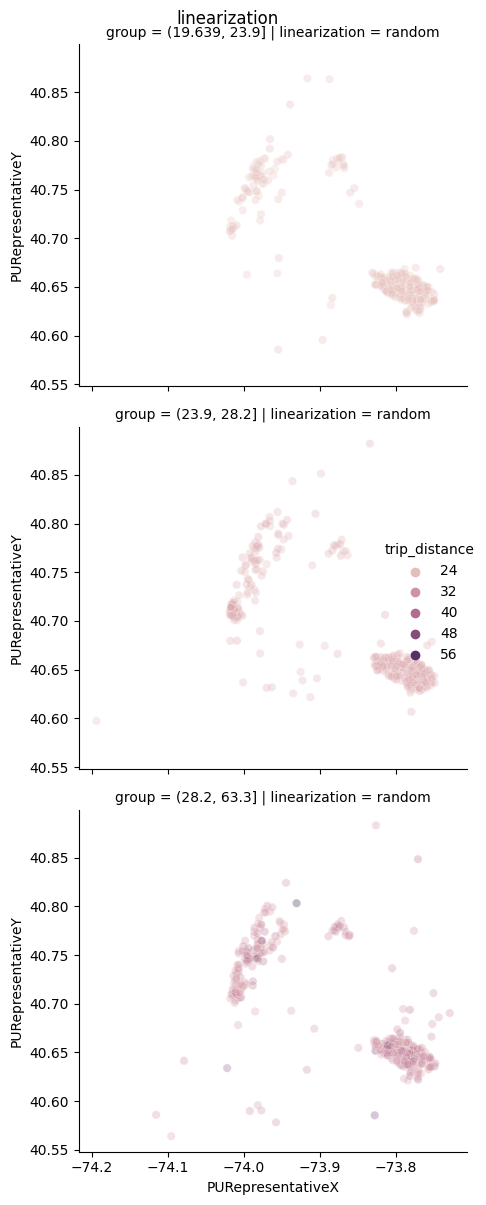

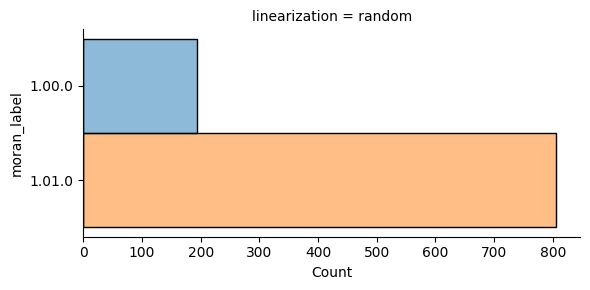

In [13]:
pl = Pipeline(base_config)

chunk = pd.DataFrame(pl.get_next_chunk(1000), columns=columns)
chunk["linearization"] = base_config["linearization"]
chunk["subdivision"] = base_config["subdivision"]
chunk["selection"] = base_config["selection"]

render_chunk(chunk, "linearization")

Changing the Linearization

preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing


C:\Users\au629923\AppData\Local\Temp\ipykernel_24960\1209943583.py:112: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.fig.show()
C:\Users\au629923\AppData\Local\Temp\ipykernel_24960\1209943583.py:112: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.fig.show()
C:\Users\au629923\AppData\Local\Temp\ipykernel_24960\1209943583.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


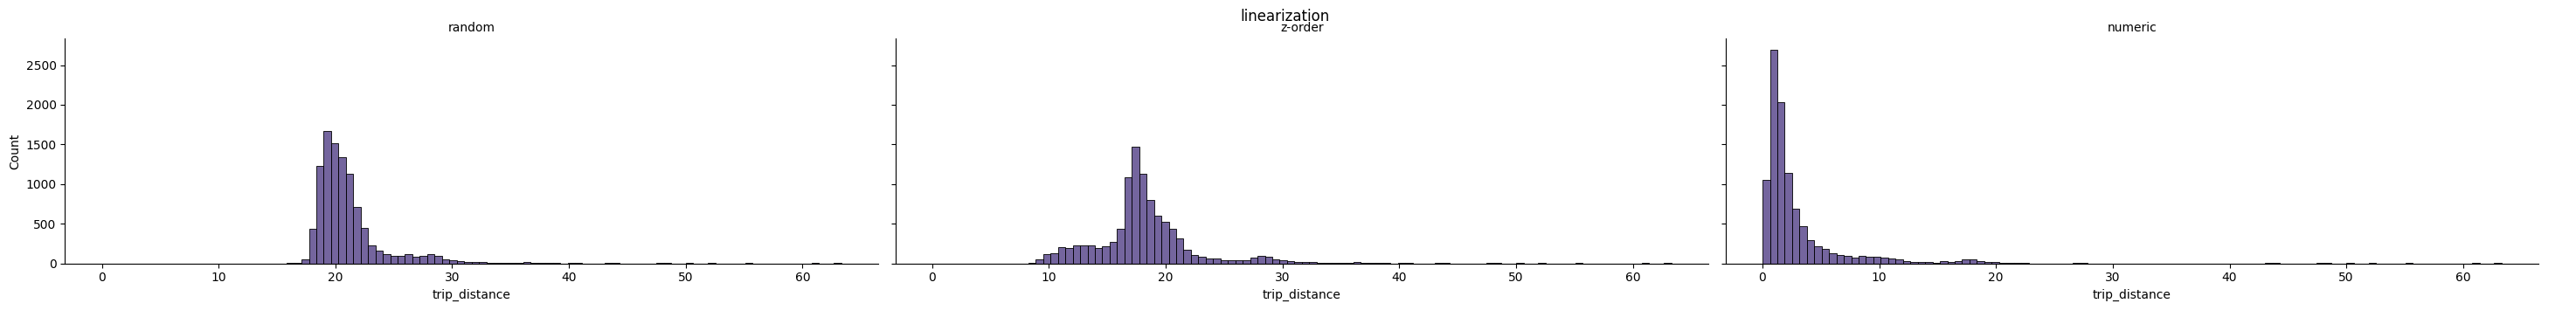

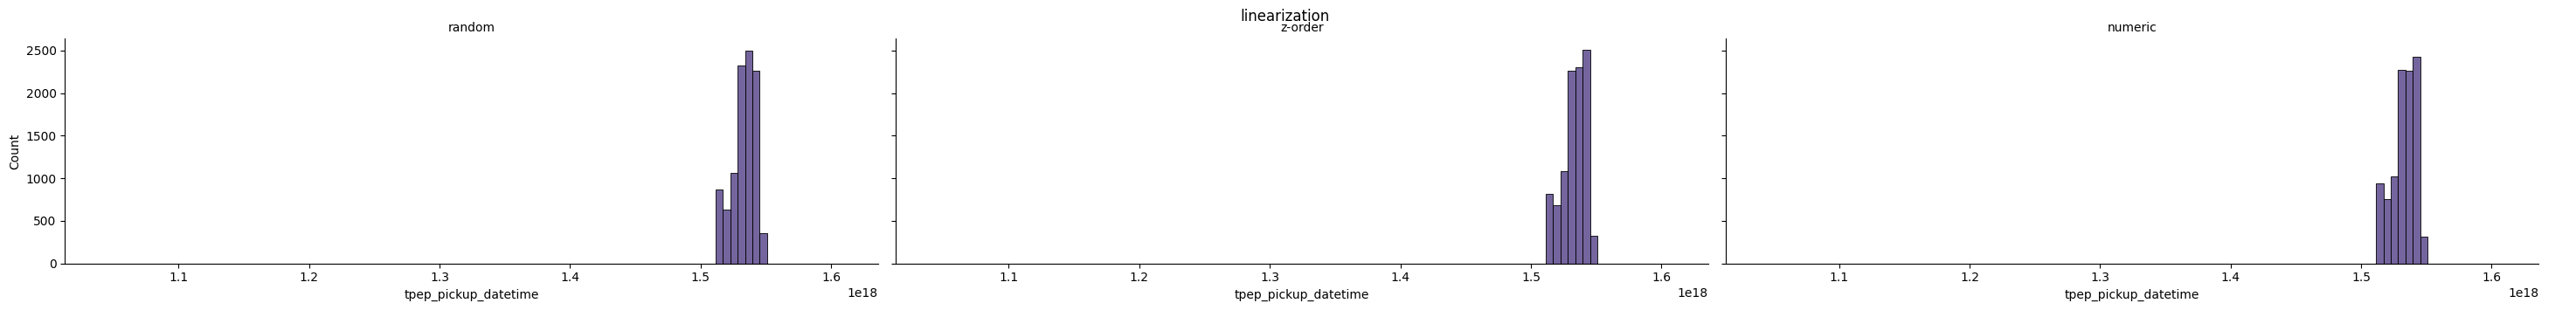

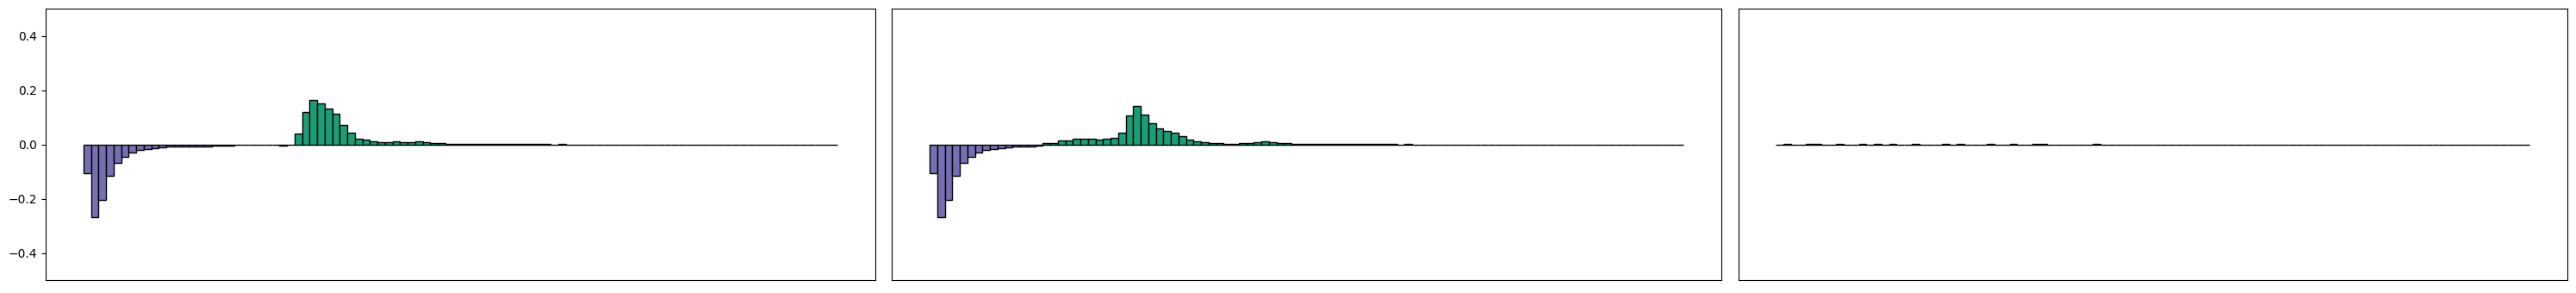

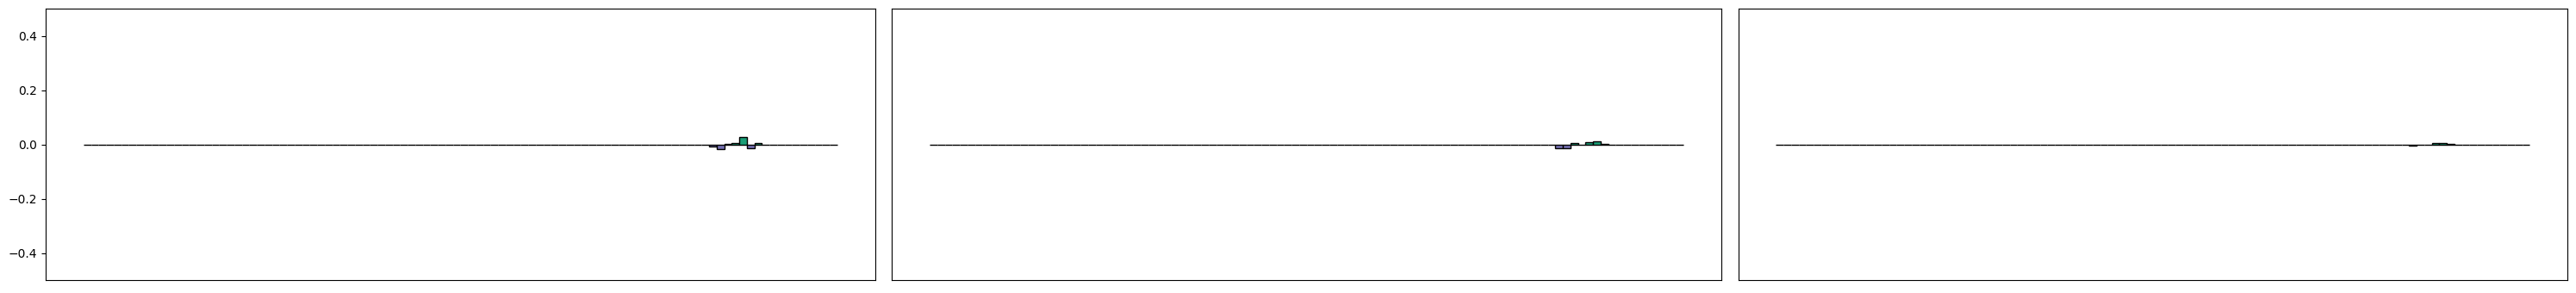

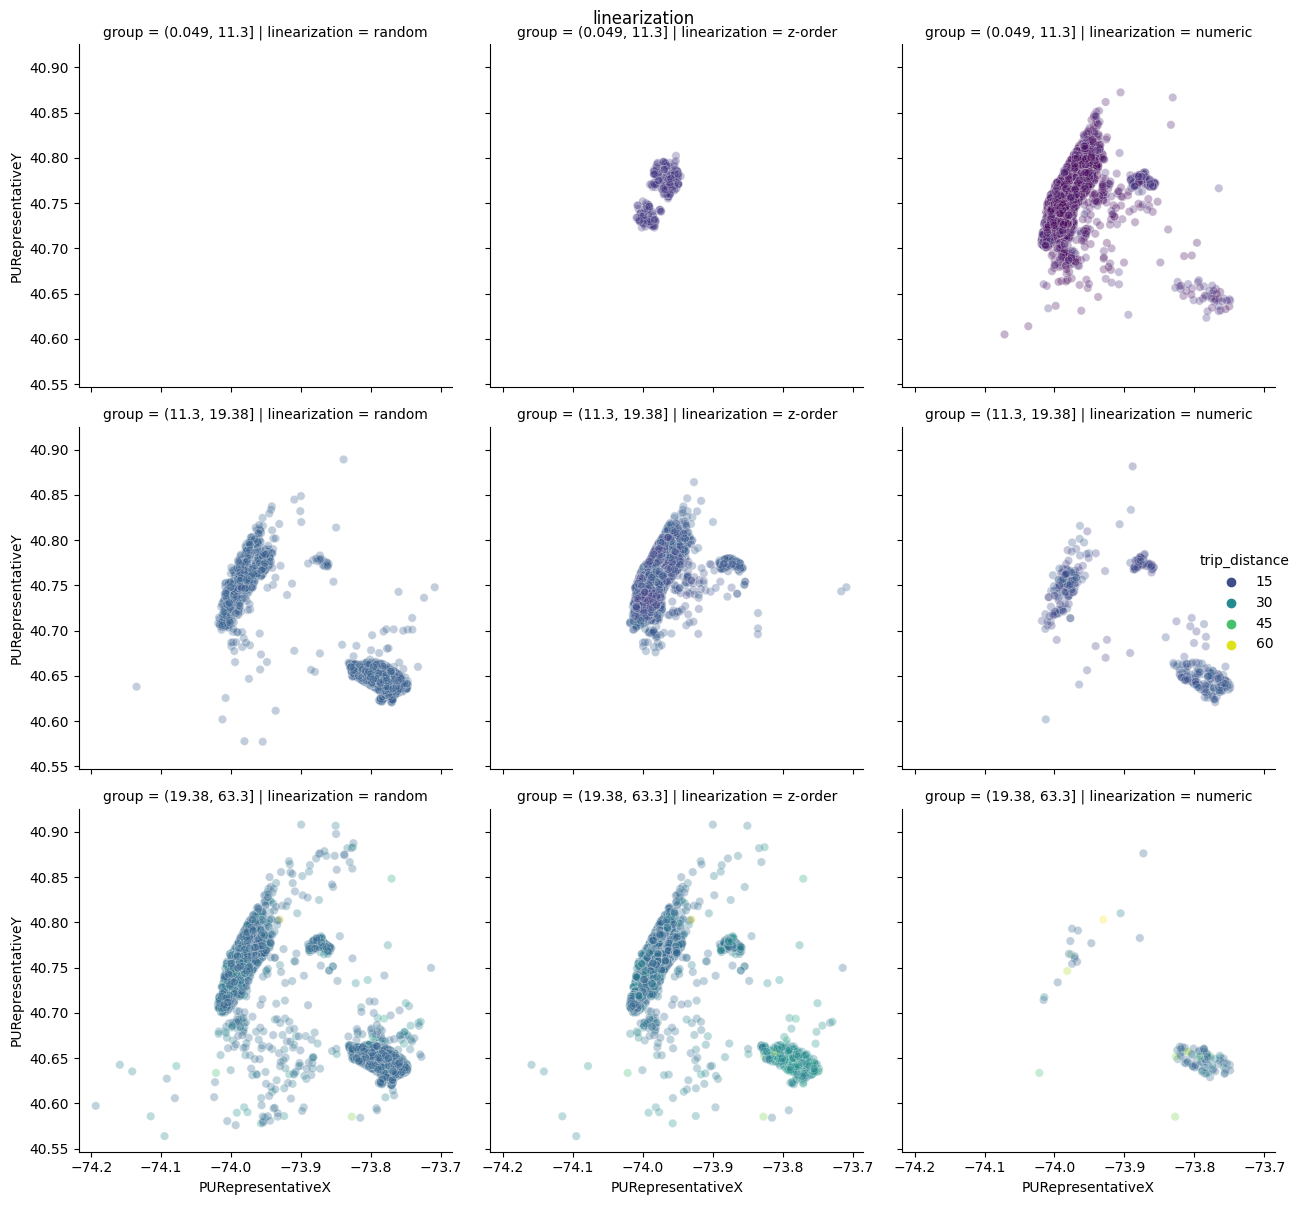

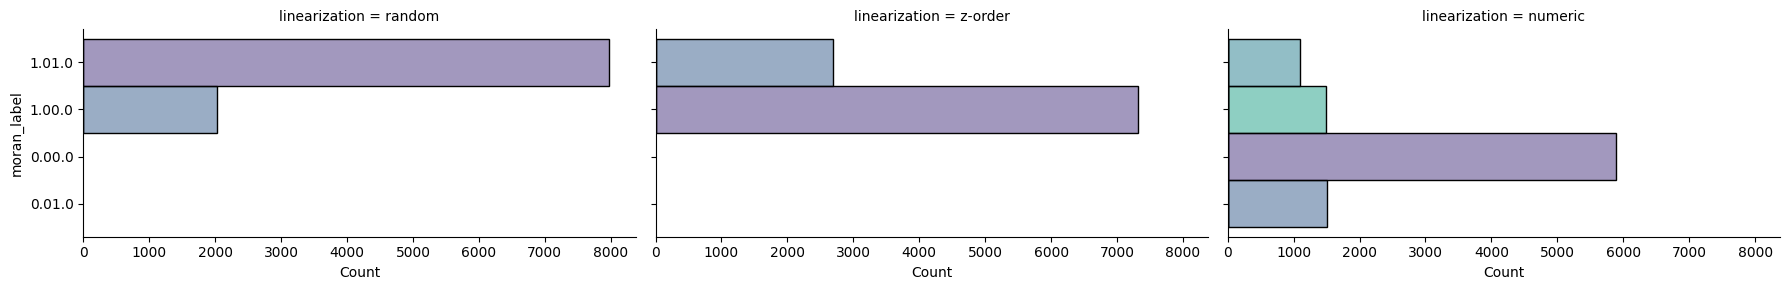

In [44]:
import pandas as pd

linearizations = ["random", "z-order", "numeric"]

df = pd.DataFrame()

for linearization in linearizations:
  config = base_config.copy()
  config["linearization"] = linearization

  pl = Pipeline(config)

  chunk = pd.DataFrame(pl.get_next_chunk(10000), columns=columns)
  chunk["linearization"] = config["linearization"]
  chunk["subdivision"] = config["subdivision"]
  chunk["selection"] = config["selection"]

  df = pd.concat([df, chunk], ignore_index=True)

render_chunk(df, "linearization")

Changing the Subdivision

C:\Users\au629923\AppData\Local\Temp\ipykernel_24960\1869448929.py:112: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.fig.show()
C:\Users\au629923\AppData\Local\Temp\ipykernel_24960\1869448929.py:112: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.fig.show()
C:\Users\au629923\AppData\Local\Temp\ipykernel_24960\1869448929.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


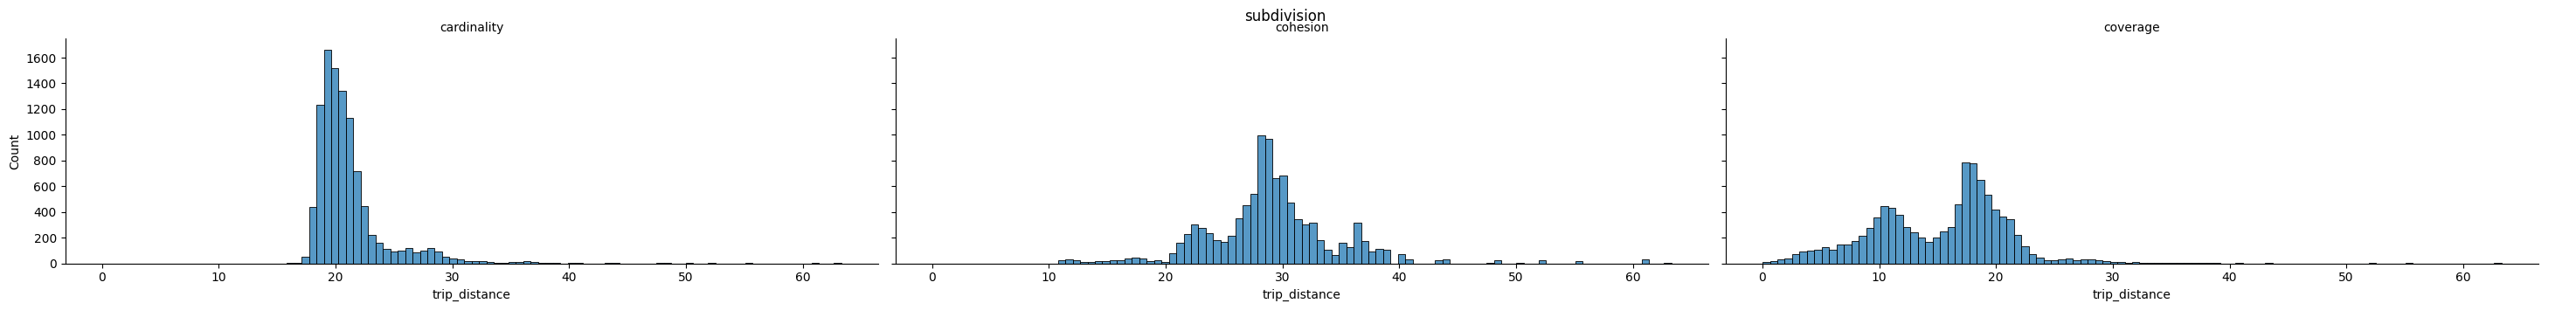

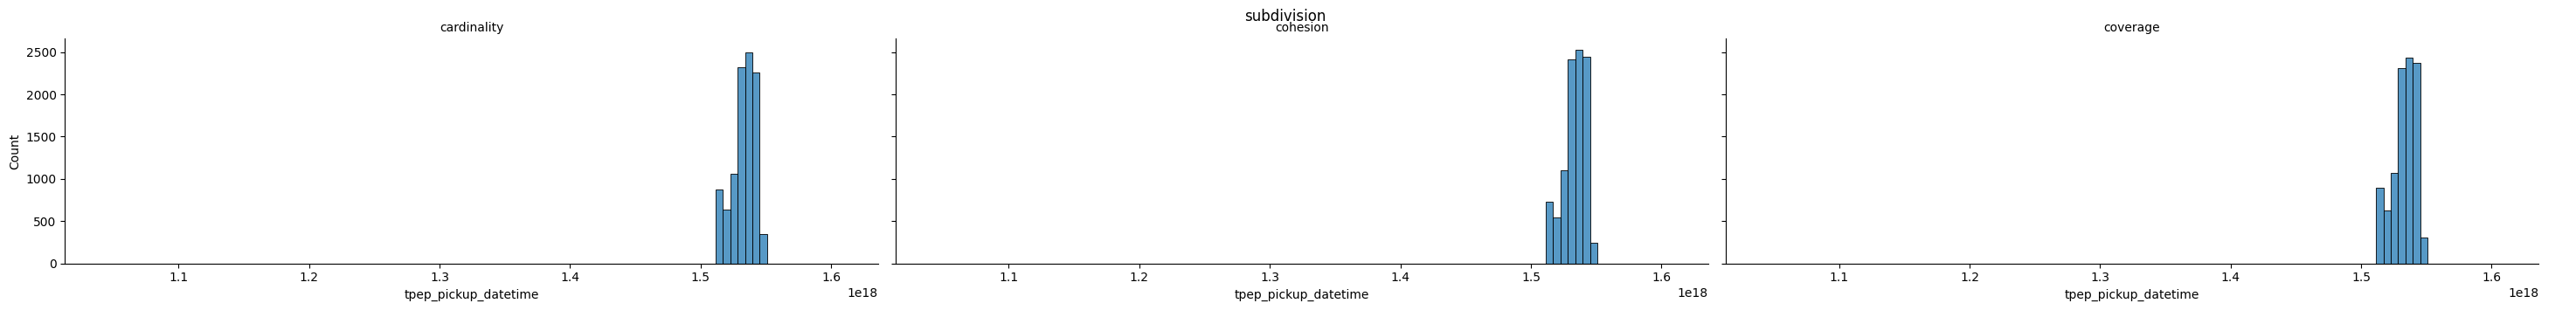

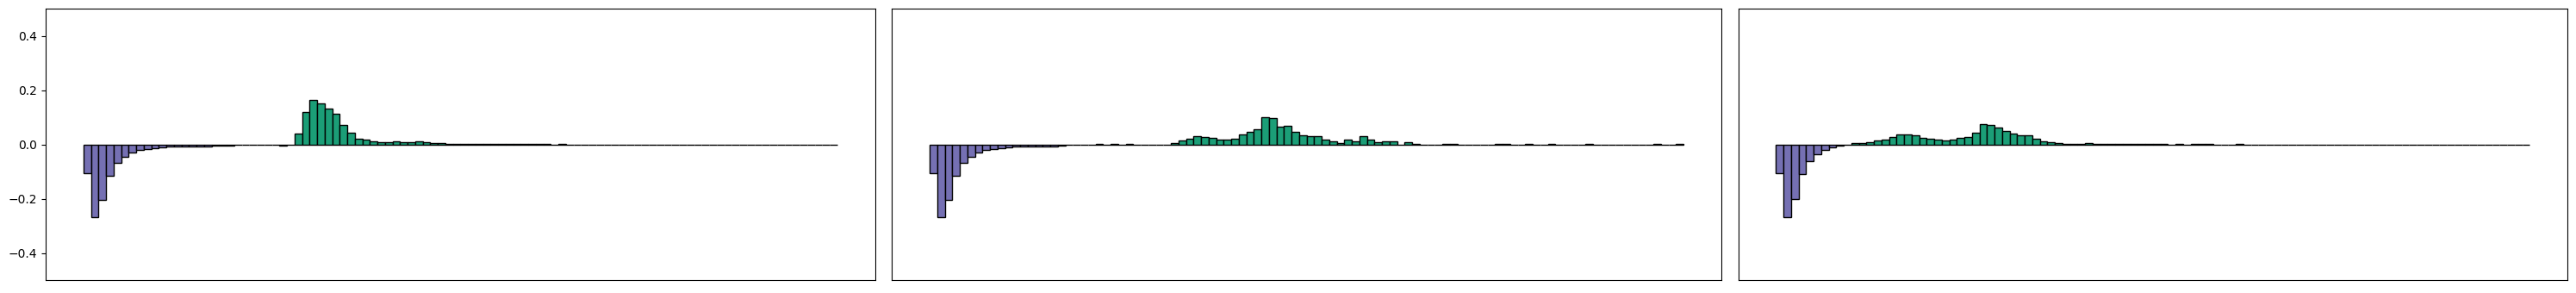

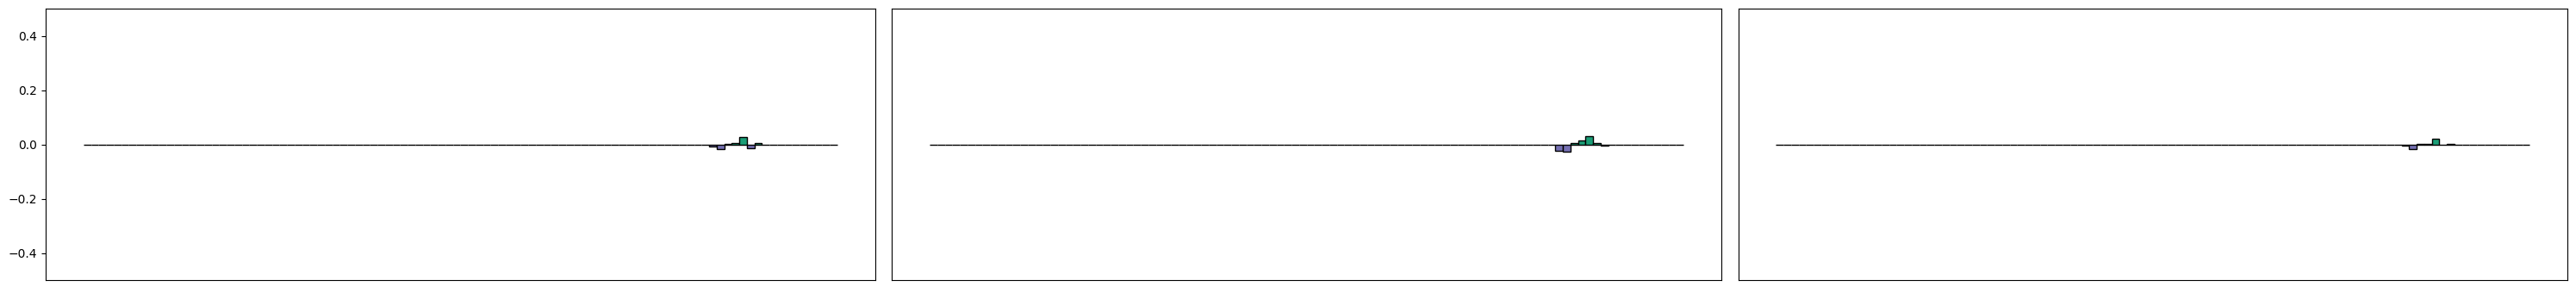

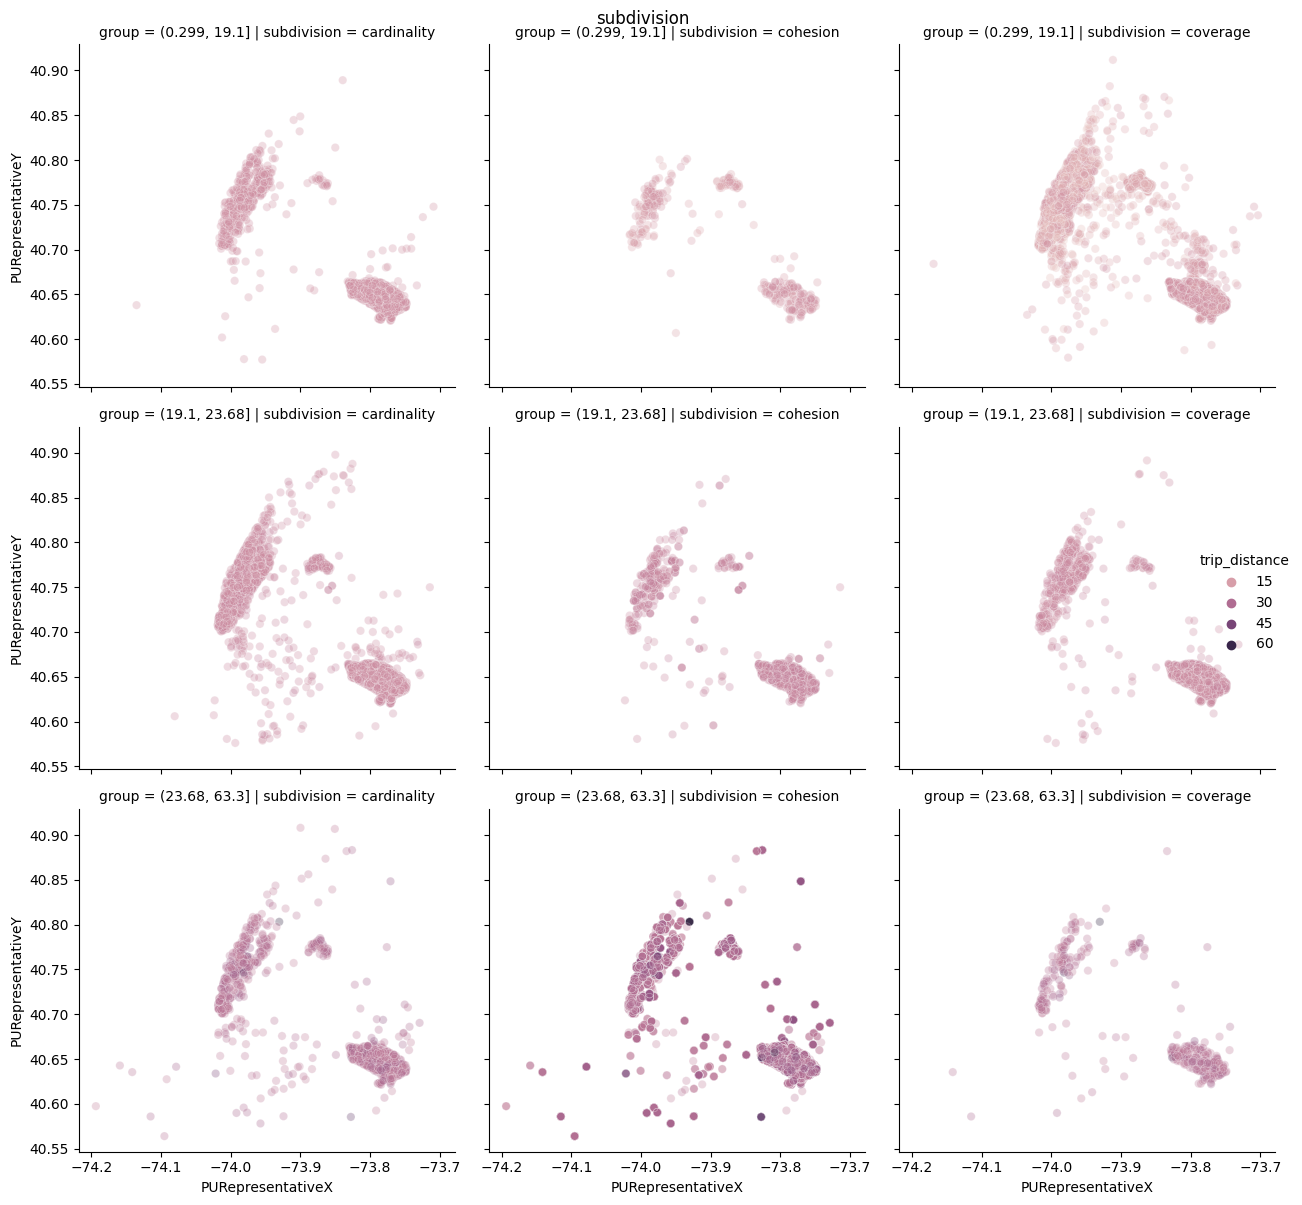

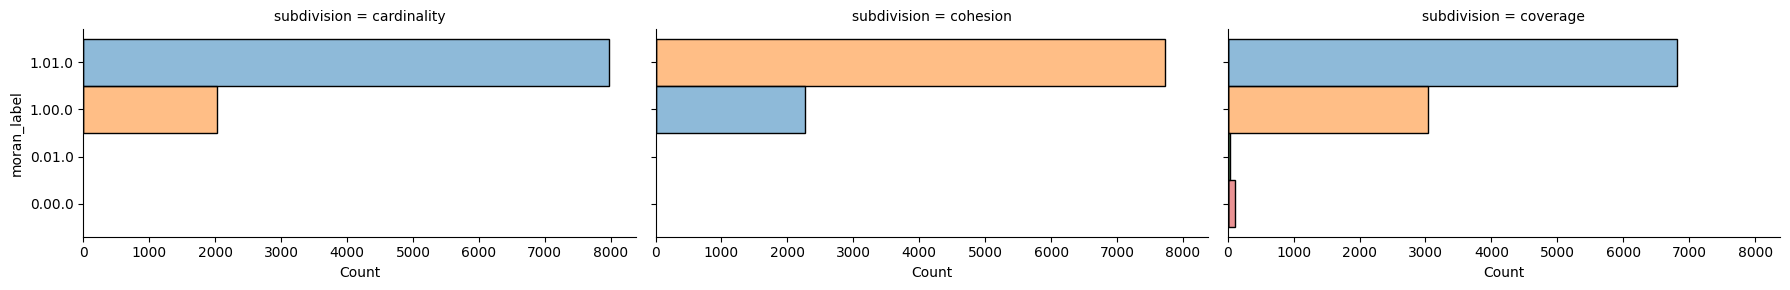

In [32]:
import pandas as pd

subdivisions = ["cardinality", "cohesion", "coverage"]

base_config_ = base_config.copy()

df = pd.DataFrame()

for subdivision in subdivisions:
  config = base_config_.copy()

  config["subdivision"] = subdivision
  pl = Pipeline(config)

  chunk = pd.DataFrame(pl.get_next_chunk(10000), columns=columns)
  chunk["linearization"] = config["linearization"]
  chunk["subdivision"] = config["subdivision"]
  chunk["selection"] = config["selection"]

  df = pd.concat([df, chunk], ignore_index=True)

render_chunk(df, "subdivision")

Changing the Selection 

In [40]:
import pandas as pd

selections = ["maximum", "median", "random"]

base_config_ = base_config.copy()

df = pd.DataFrame()

for selection in selections:
  config = base_config.copy()
  config["selection"] = selection
  pl = Pipeline(config)

  chunk = pd.DataFrame(pl.get_next_chunk(3333), columns=columns)
  chunk["linearization"] = config["linearization"]
  chunk["subdivision"] = config["subdivision"]
  chunk["selection"] = config["selection"]

  df = pd.concat([df, chunk], ignore_index=True)

render_chunk(df, "selection")

preprocessing pipeline ...


KeyboardInterrupt: 

## Discussion section

### Effect of changing chunk size on selection runtime

In [ ]:
import pandas as pd
import time

start = time.time()
config = base_config.copy()
config["subdivision"] = "cohesion"  # creates "uneven" number of bins
config["selection"] = "median"  # complex selection strategy

pl = Pipeline(config)
print(f"preprocessing took {time.time() - start}s")

chunk_sizes = [100, 313, 1000, 1763, 2000, 5000, 10000, 56721, 100000]

runtimes = []

for chunk_size in chunk_sizes:
  now = time.time()
  chunk = pd.DataFrame(pl.get_next_chunk(chunk_size), columns=columns)
  runtime = time.time() - now
  runtimes += [(chunk_size, runtime)]

print("\ntotal", time.time() - start)
pd.DataFrame(runtimes, columns=["chunk_size", "runtime"])

### Recreating existing sampling strategies

preprocessing pipeline ...
Done with the pre-processing
got 10000 items
preprocessing pipeline ...
Done with the pre-processing
got 10000 items
preprocessing pipeline ...
Done with the pre-processing
got 10000 items


C:\Users\au629923\AppData\Local\Temp\ipykernel_24960\1869448929.py:112: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.fig.show()
C:\Users\au629923\AppData\Local\Temp\ipykernel_24960\1869448929.py:112: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.fig.show()
C:\Users\au629923\AppData\Local\Temp\ipykernel_24960\1869448929.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


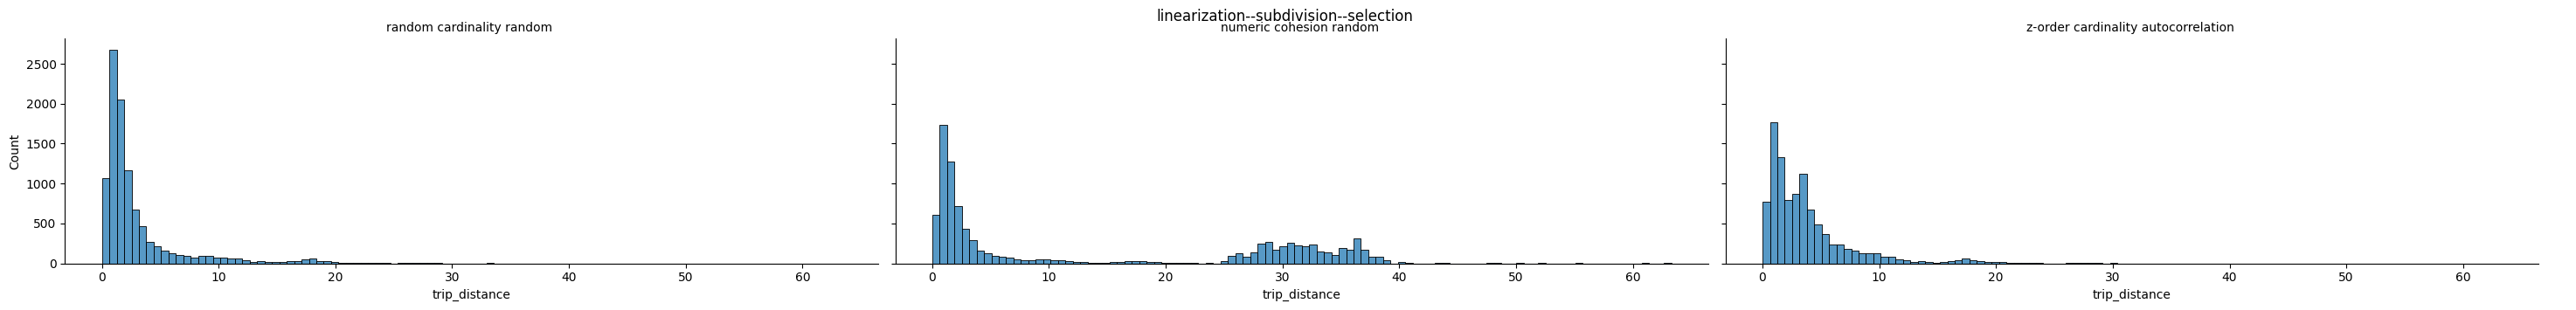

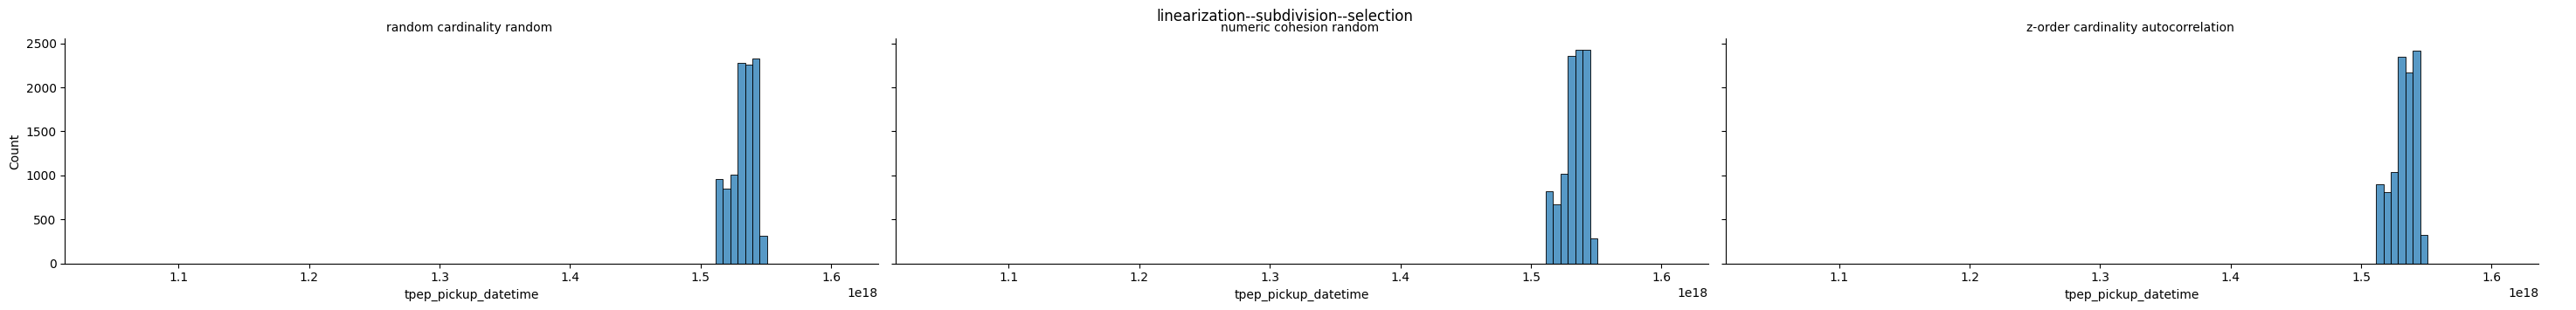

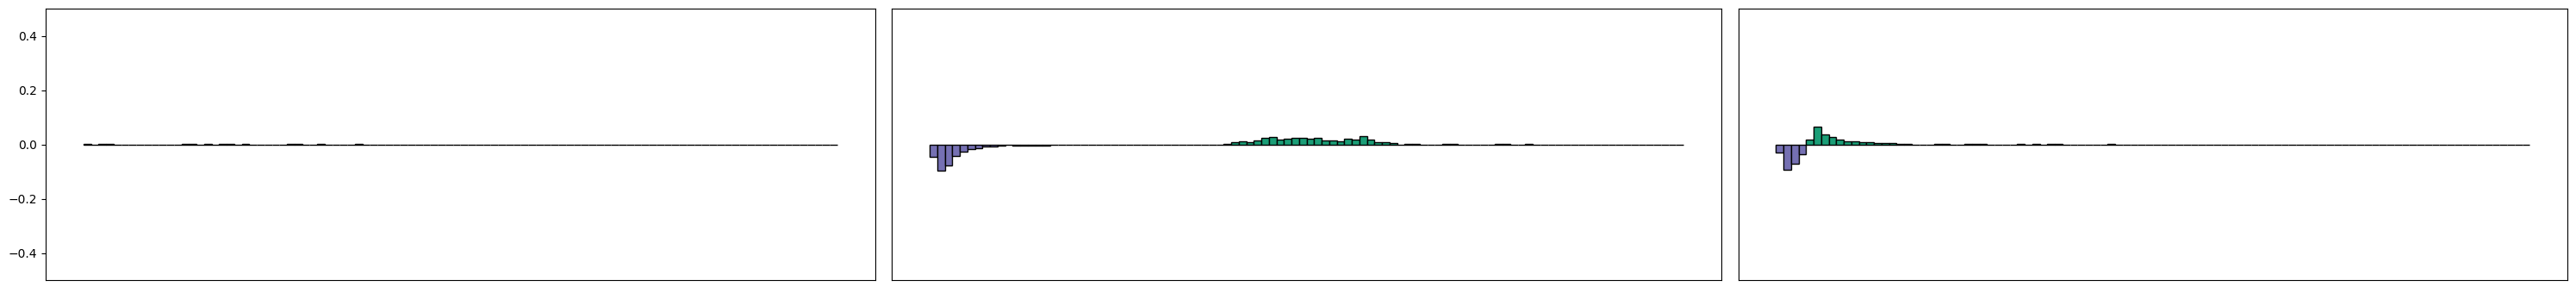

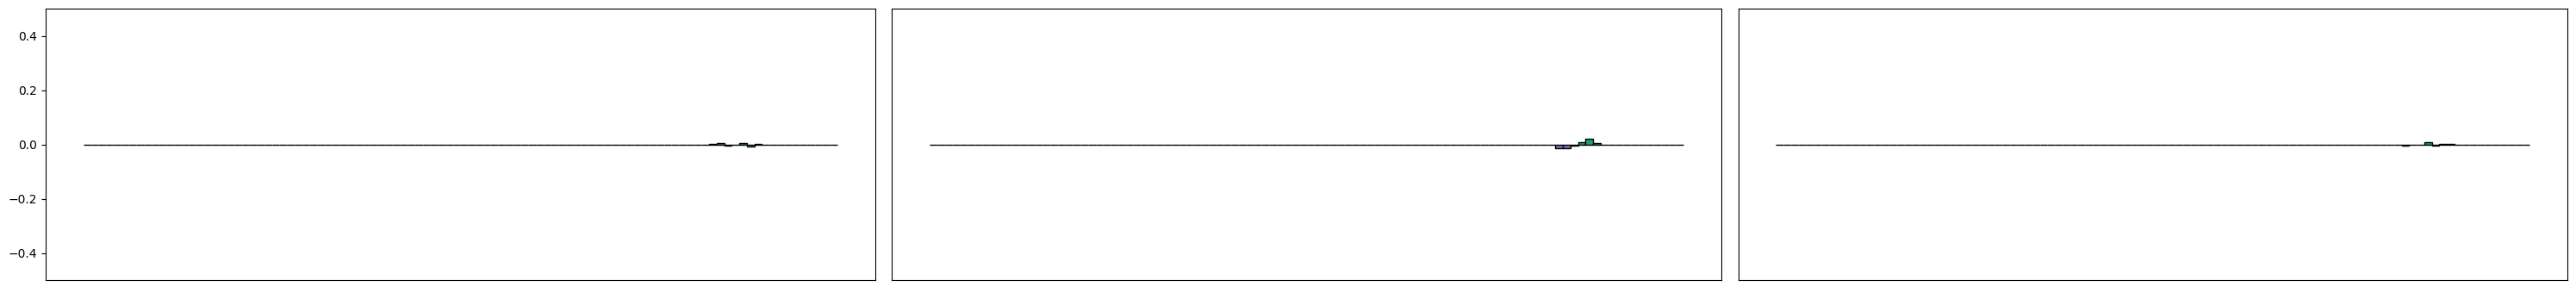

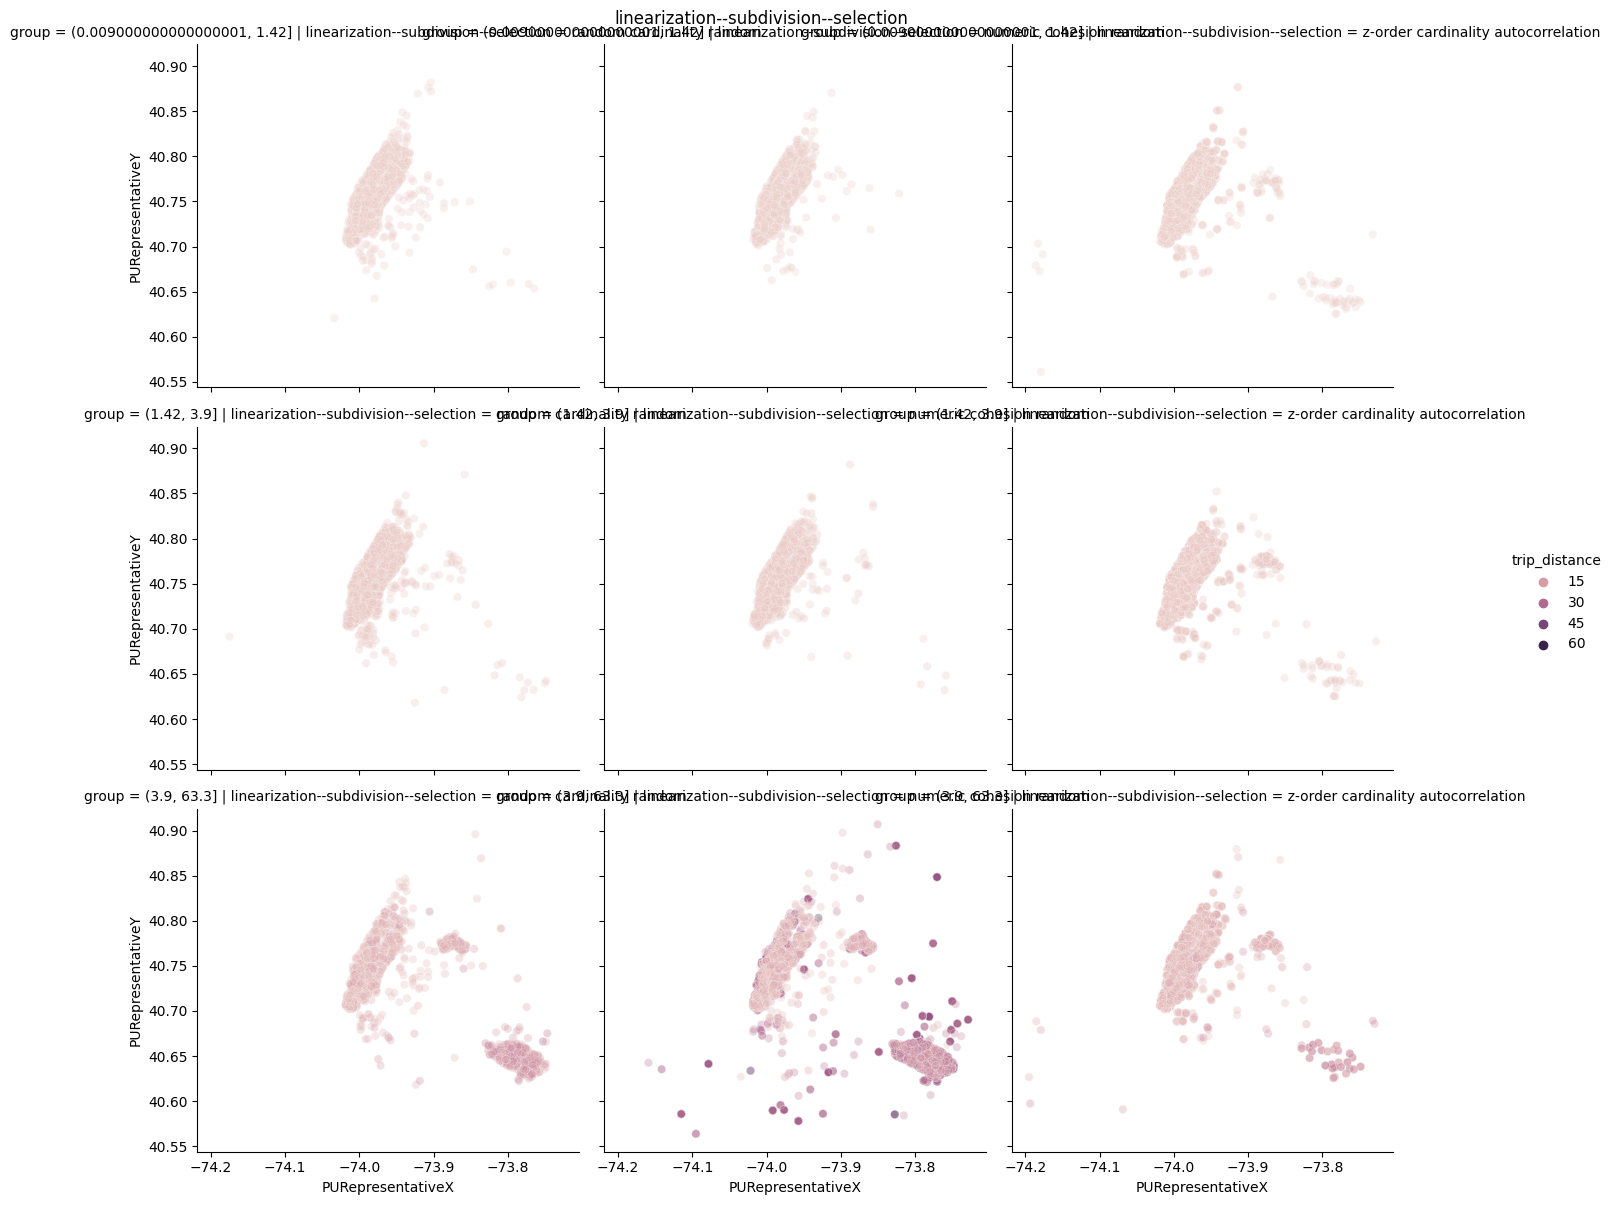

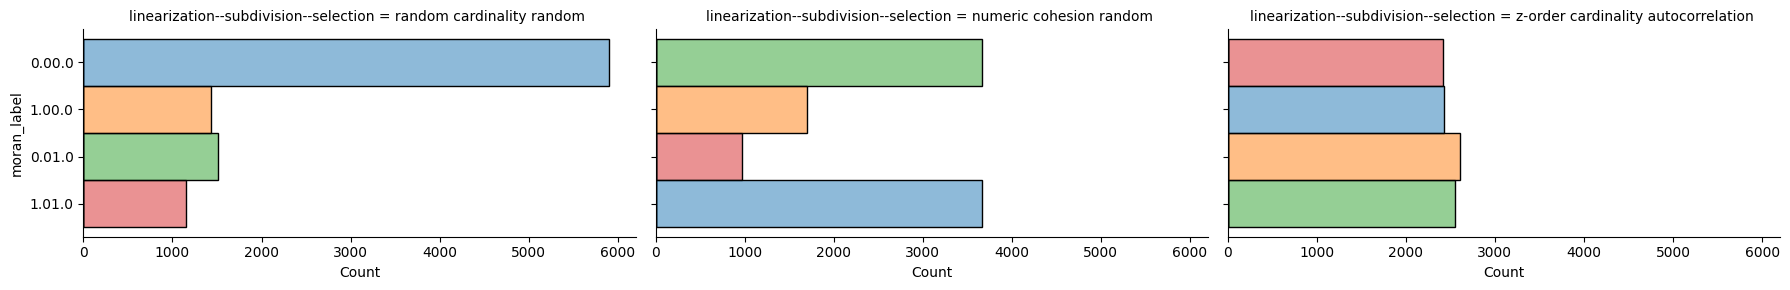

In [34]:
import pandas as pd

random_config = {
  "data": "taxis",
  "linearization": "random",
  "subdivision": "cardinality",
  "selection": "random",
  "dimension": 5,
  "params": {
    "subspace": [17, 18],  # pickup location
  }
}

stratified_config = {
  "data": "taxis",
  "linearization": "numeric",
  "subdivision": "cohesion",
  "selection": "random",
  "dimension": 5,
  "params": {
    "subspace": [5],
    "value_h_index": 23,
    "lag_h_index": 24
  }
}

z_order_config = {
  "data": "taxis",
  "linearization": "z-order",
  "subdivision": "cohesion",
  "selection": "median",
  "dimension": 5,  # spatial autocorrelation
  "params": {
    "subspace": [17, 18],  # pickup location
  }
}

autocorrelation_config = {
  "data": "taxis",
  "linearization": "z-order",
  "subdivision": "cardinality",
  "selection": "autocorrelation",
  "dimension": 5,  # spatial autocorrelation
  "params": {
    "subspace": [17, 18],  # pickup location
    "value_h_index": 23,
    "lag_h_index": 24
  }
}

combinations = [
  ("random", random_config),
  ("stratified", stratified_config),
  # ("z-order", z_order_config),
  ("autocorrelation", autocorrelation_config),
]

df = pd.DataFrame()

for name, config in combinations:
  pl = Pipeline(config)

  chunk = pd.DataFrame(pl.get_next_chunk(10000), columns=columns)

  chunk["linearization"] = config["linearization"]
  chunk["subdivision"] = config["subdivision"]
  chunk["selection"] = config["selection"]

  df = pd.concat([df, chunk], ignore_index=True)

render_chunk(df, ["linearization", "subdivision", "selection"])

### Tailoring the sampling to multiple attributes

preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing


C:\Users\au629923\AppData\Local\Temp\ipykernel_23536\3931872936.py:115: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.fig.show()
C:\Users\au629923\AppData\Local\Temp\ipykernel_23536\3931872936.py:115: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.fig.show()
C:\Users\au629923\AppData\Local\Temp\ipykernel_23536\3931872936.py:88: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


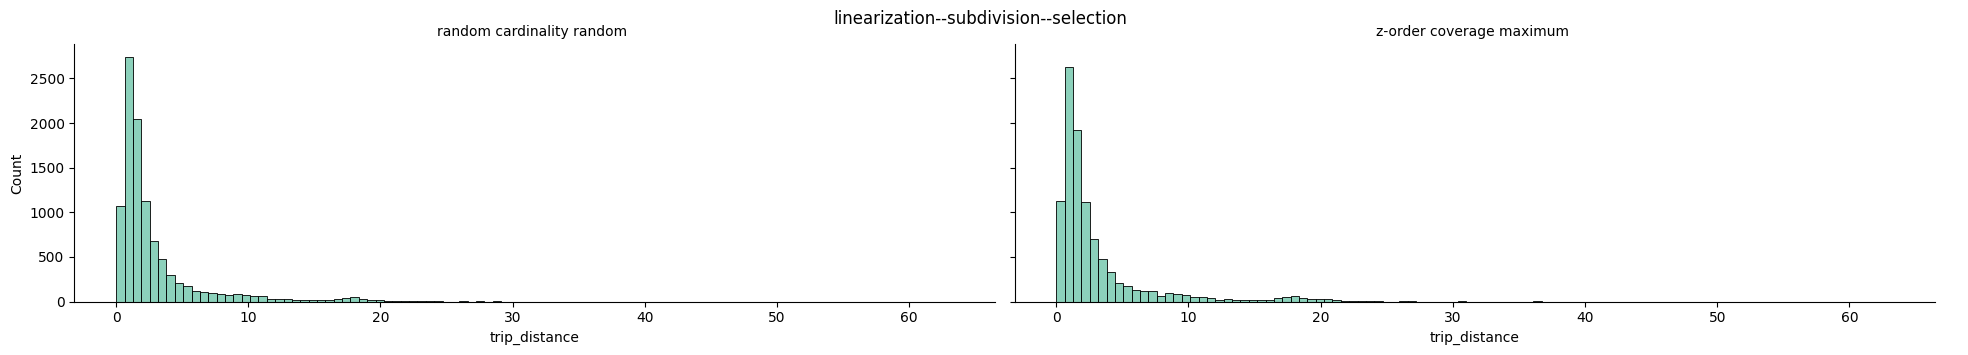

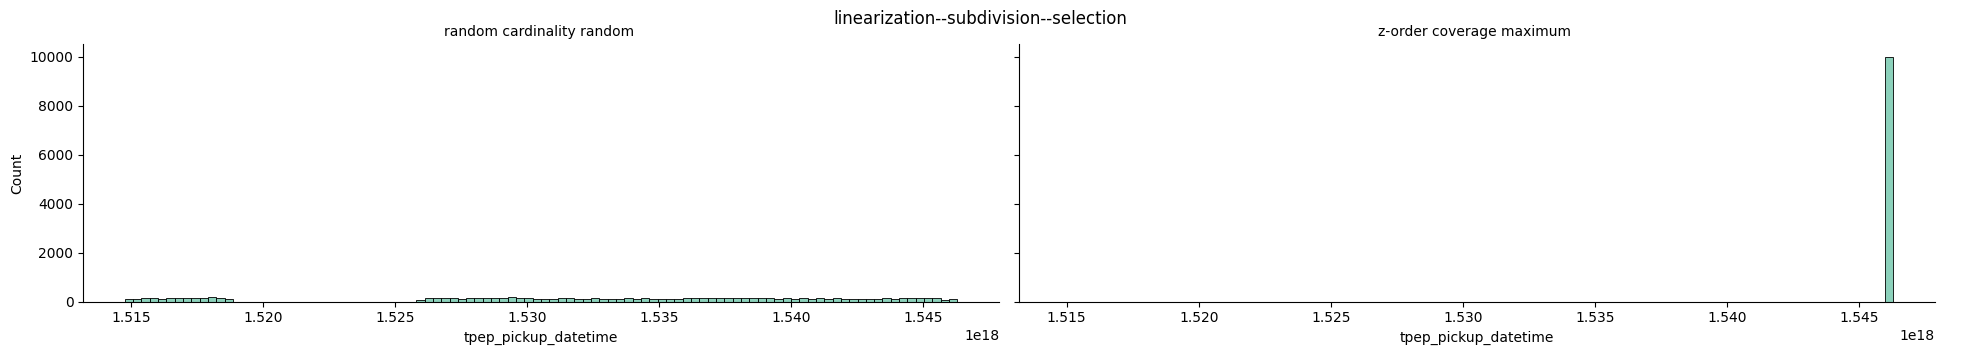

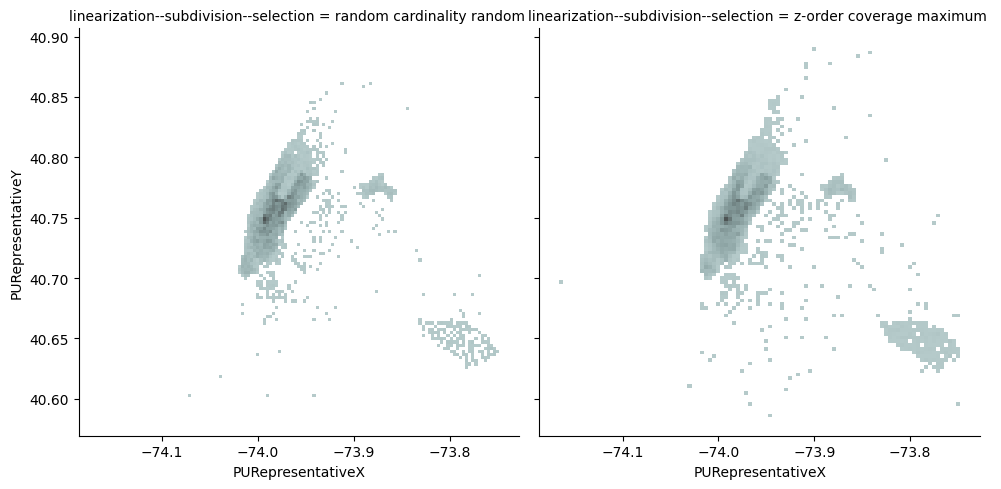

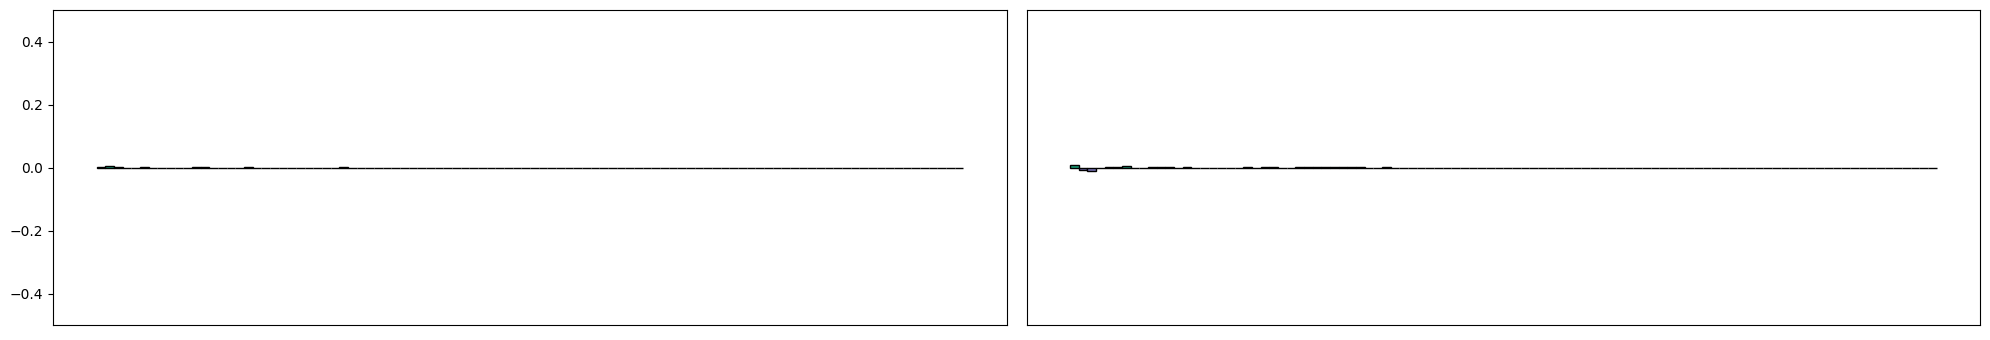

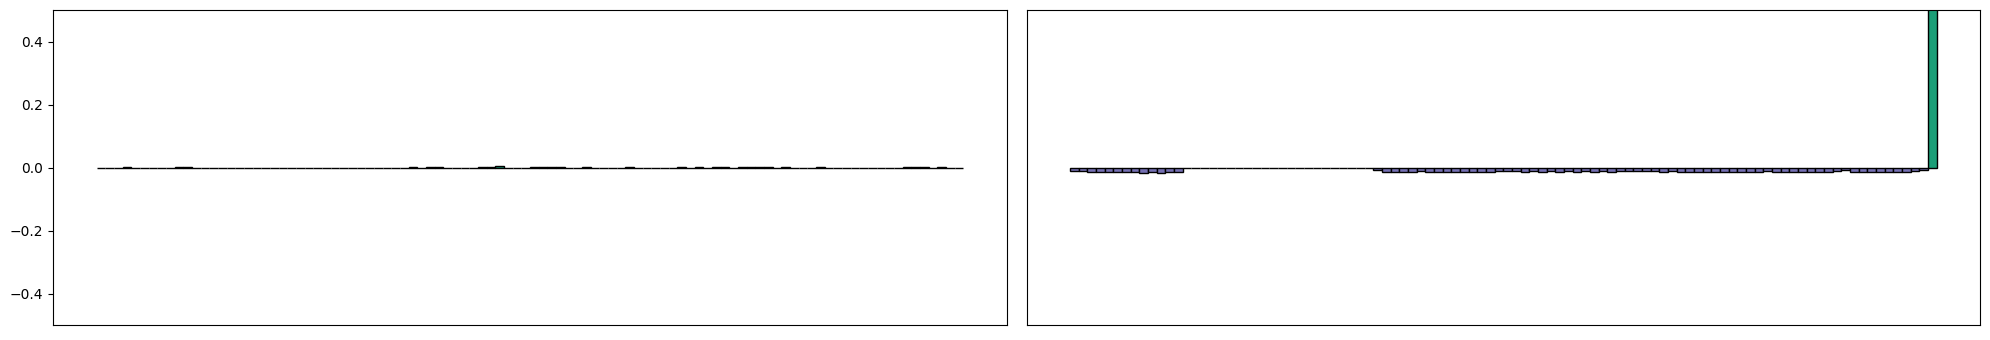

In [47]:
import pandas as pd

base_config_ = base_config.copy()
base_config_["selection"] = "random"

multiple_attr_config = {
  "data": "taxis",
  "linearization": "z-order",
  "subdivision": "coverage",
  "selection": "maximum",
  # "dimension": 5,  # trip distance
  "dimension": 2,  # pickup time
  "params": {
    "subspace": [17, 18],  # pickup location,
    # "coverage": 16,  # total amount
    "coverage": 5,  # trip distance
    # "coverage": 2,  # pickup time
    "value_h_index": 23,
    "lag_h_index": 24,
  }
}

df = pd.DataFrame()

configs = [base_config_, multiple_attr_config]

for config in configs:
  pl = Pipeline(config)

  chunk = pd.DataFrame(pl.get_next_chunk(10000), columns=columns)
  chunk["linearization"] = config["linearization"]
  chunk["subdivision"] = config["subdivision"]
  chunk["selection"] = config["selection"]

  df = pd.concat([df, chunk], ignore_index=True)

render_chunk(df, ["linearization", "subdivision", "selection"])

### Reusing operators for tailoring the pipeline

preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing


C:\Users\au629923\AppData\Local\Temp\ipykernel_23536\3931872936.py:115: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.fig.show()
C:\Users\au629923\AppData\Local\Temp\ipykernel_23536\3931872936.py:115: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.fig.show()
C:\Users\au629923\AppData\Local\Temp\ipykernel_23536\3931872936.py:88: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


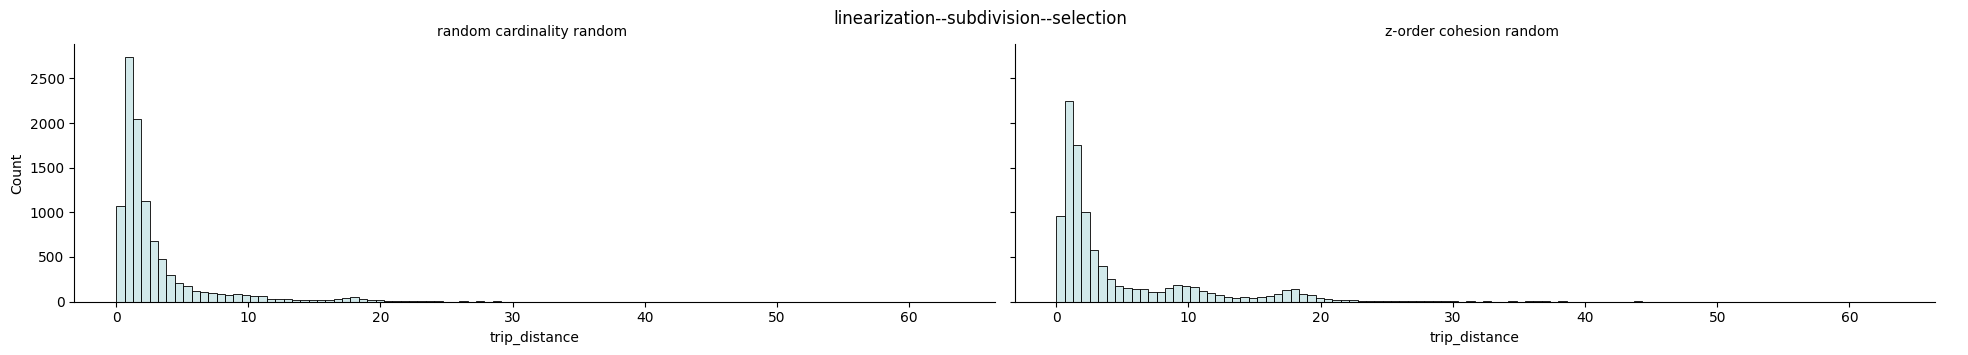

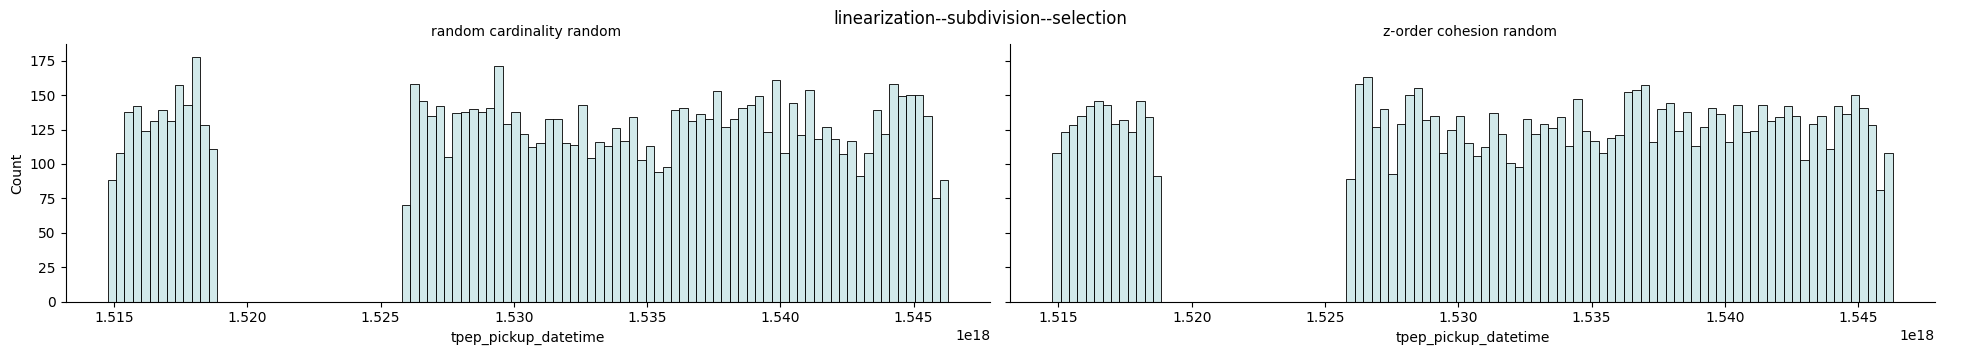

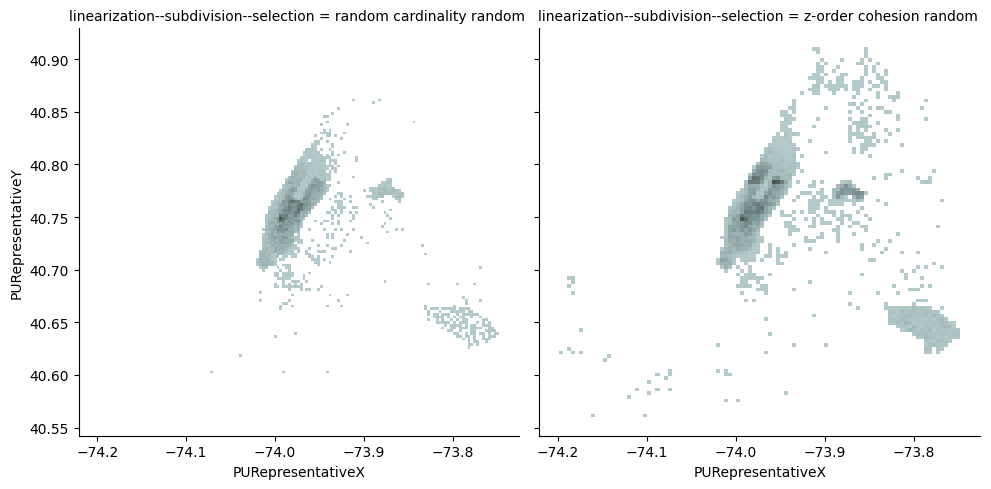

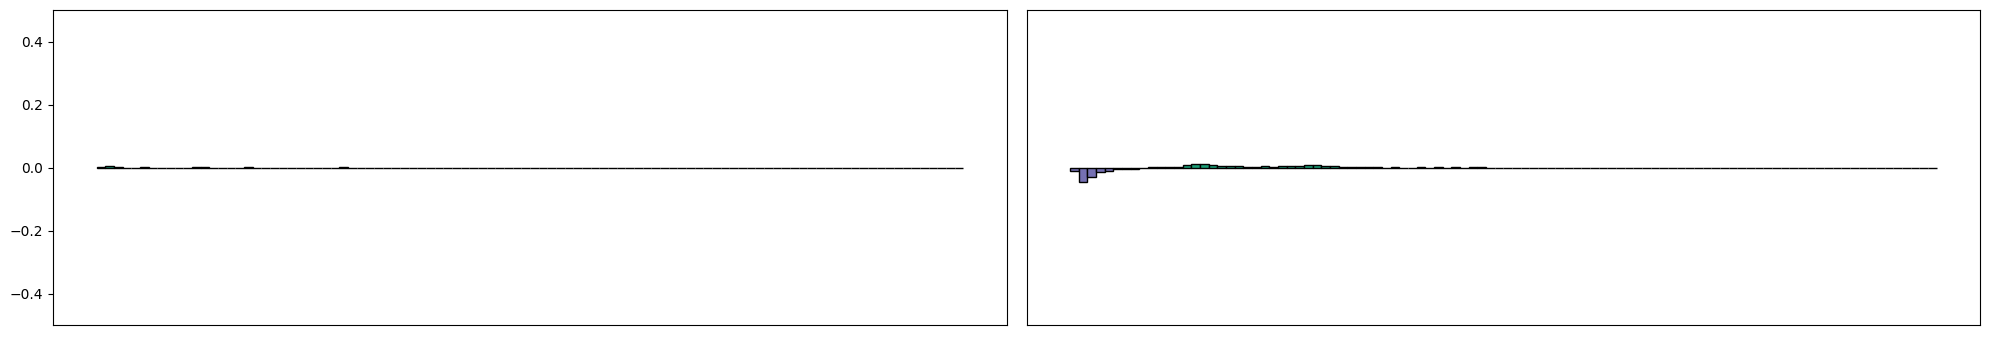

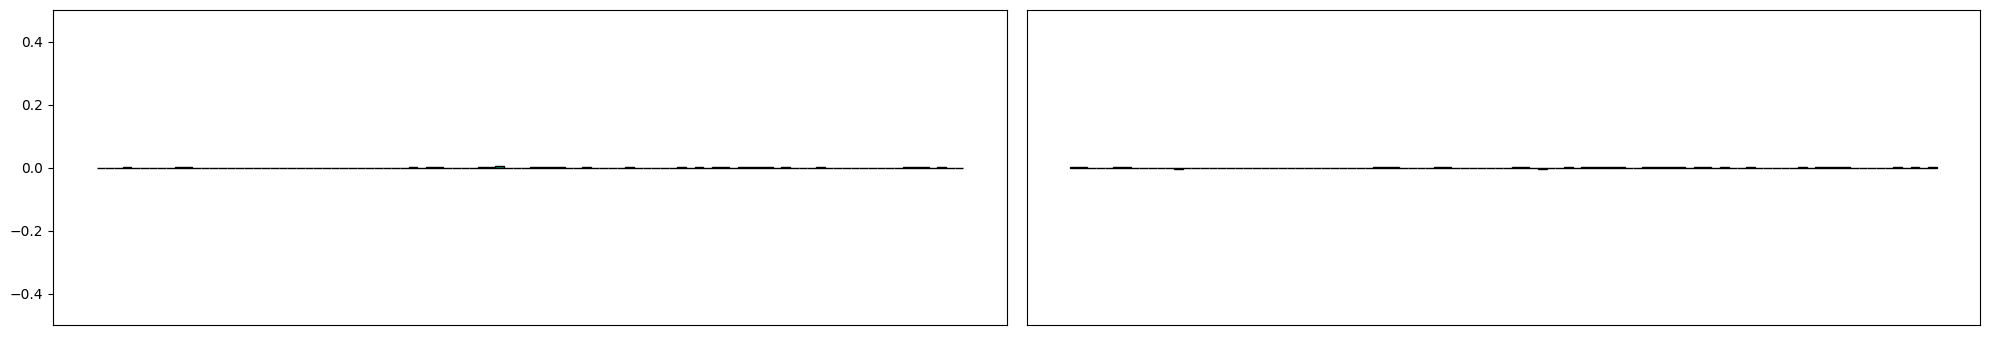

In [49]:
recomposing_pipelines_config = {
  "data": "taxis",
  "linearization": "z-order",
  "subdivision": "cohesion",
  "selection": "random",
  "dimension": 5,  # spatial autocorrelation
  "params": {
    "subspace": [17, 18],  # pickup location,
    # "coverage": 16,  # total amount
    
    "coverage": 5,  # trip distance
    "value_h_index": 23,
    "lag_h_index": 24,
  }
}

df = pd.DataFrame()

configs = [base_config_, recomposing_pipelines_config]

for config in configs:
  pl = Pipeline(config)

  chunk = pd.DataFrame(pl.get_next_chunk(10000), columns=columns)
  chunk["linearization"] = config["linearization"]
  chunk["subdivision"] = config["subdivision"]
  chunk["selection"] = config["selection"]

  df = pd.concat([df, chunk], ignore_index=True)

render_chunk(df, ["linearization", "subdivision", "selection"])

In [42]:
type(gt_df["tpep_pickup_datetime"].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp